# Neighborhood expansion methods

This notebook will provide an overview of different methods that we propose to expand the neighborhood of certain leaf nodes of a subtree of a larger undirected graph. We will use such methods to expand the neighborhood of different Steiner tree and Prize-collecting Steiner tree solutions that are supposed to describe a subnetwork of an interactome.

---

## 0. Environmental setup

In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.approximation import steinertree
from pcst_fast import pcst_fast

import random

random.seed(1234)
np.random.seed(1234)

import sys

sys.path.append("../..")

## 1. Generate the input data

First, we will generate the required input data. To this end, we will generate an undirected graph of $n=15$ nodes and randomly assign edge weights to that graph.

In [2]:
n = 15
p = 0.5

In [3]:
graph = nx.generators.random_graphs.fast_gnp_random_graph(n,p, seed=1234)
for (u, v) in graph.edges():
    graph.edges[u,v]['cost'] = np.round(np.random.uniform(), decimals=2)
labels = nx.get_edge_attributes(graph,'cost')

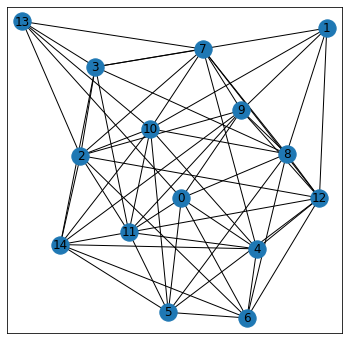

In [4]:
pos = nx.spring_layout(graph, seed=1234)
plt.figure(figsize=[6,6])
#nx.draw_networkx_edge_labels(graph,pos=pos,edge_labels=labels)
nx.draw_networkx(graph, pos=pos)

Next, we will chose a subset of nodes of that network of size $p = 5$ and compute the Steiner tree solution.
Let us pick those four nodes just randomly from the complete node set.

In [5]:
p=5
vertices = list(graph.nodes())
terminals = np.random.choice(vertices, size=p, replace=False)

The terminals that we selected are the following.

In [6]:
terminals

array([8, 3, 5, 0, 6])

Let us highlight those in the network graph using a red color.

In [7]:
terminal_dict = {}
colors=[]
for node in graph.nodes():
    terminal_dict[node] = node in terminals
    if terminal_dict[node]:
        colors.append("red")
    else:
        colors.append("yellow")
nx.set_node_attributes(graph, terminal_dict, "terminal")

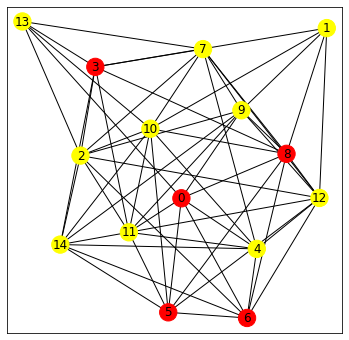

In [8]:
plt.figure(figsize=[6,6])
#nx.draw_networkx_edge_labels(graph,pos=pos,edge_labels=labels)
nx.draw_networkx(graph, node_color=colors, pos=pos)

Now let us compute the Steiner Tree solution.

In [9]:
steiner_tree = steinertree.steiner_tree(graph, terminals, weight="cost")

We will now also color the edges of the Steiner tree solution in the graph in yellow.

In [10]:
edge_colors = []
for edge in graph.edges():
    if edge in steiner_tree.edges():
        edge_colors.append("red")
    else:
        edge_colors.append("black")

node_colors = []
for node in graph.nodes():
    if node in steiner_tree.nodes():
        node_colors.append("red")
    else:
        node_colors.append("yellow")


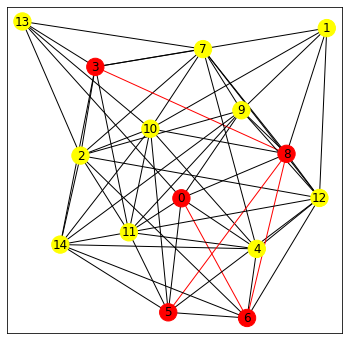

In [11]:
plt.figure(figsize=[6,6])
#nx.draw_networkx_edge_labels(graph,pos=pos,edge_labels=labels)
nx.draw_networkx(graph, node_color=node_colors, edge_color=edge_colors, pos=pos)

---

## 2. Expansion methods

In the following we will now describe and visualize different expansion methods that we propose. All of these methods aim to expand the Steiner tree solution such that none of the terminals is a leaf anymore. In that sense the objective is related to the one of the so called internal Steiner Tree problem.

### 2.1. kNN expansion

The first method is the so called kNN expansion. Hereby, the algorithm will iterate over the edge set of the derived Steiner tree solution and simply add the k-nearest neighbor nodes to each terminal node that forms a leaf in the Steiner tree by adding the respective edges from those leaf nodes to their neighbors. Note that this method is not guaranteed to preserve the tree structure of the graph it works on but my introduce cycles. Additionally, the method will only add first-order neighbors, although extensions to higher order neighborhoods are straight-forward.

In [12]:
def knn_expansion(
    graph, steiner_tree, terminals, k=1
):
    steiner_tree_edges = list(steiner_tree.edges(data=True))
    extended_edges = []
    for node in steiner_tree.nodes():
        if steiner_tree.degree(node) == 1 and node in terminals:
            leaf_neighbor_connections = graph.edges(node, data=True)
            edge_cost_dict = {}
            for i, edge in enumerate(leaf_neighbor_connections):
                if edge not in steiner_tree.edges():
                    edge_cost_dict[i] = edge[-1]["cost"]
            sorted_edge_cost_dict = {
                    k: v
                for k, v in sorted(edge_cost_dict.items(), key=lambda item: item[1])
                }
            for i in range(min(k, len(sorted_edge_cost_dict))):
                extended_edges.append(
                        list(leaf_neighbor_connections)[
                            list(sorted_edge_cost_dict.keys())[i]
                        ]
                    )
    extended_edges = extended_edges + steiner_tree_edges
    all_edges = []
    for edge in extended_edges:
        all_edges.append((edge[0], edge[1]))
    steiner_tree = graph.edge_subgraph(all_edges)
    return steiner_tree

In [13]:
expanded_steiner_tree = knn_expansion(graph, steiner_tree, terminals, k=1)

Let us now color the expanded Steiner Tree graph. We will color the orginal solution as before and the added nodes and edges in orange.

In [14]:
node_colors=[]
for node in graph.nodes():
    if node in steiner_tree.nodes():
        node_colors.append("red")
    elif node in expanded_steiner_tree.nodes():
        node_colors.append("green")
    else:
        node_colors.append("yellow")
        
edge_colors = []
for edge in graph.edges():
    if edge in steiner_tree.edges():
        edge_colors.append("red")
    elif edge in expanded_steiner_tree.edges():
        edge_colors.append("green")
    else:
        edge_colors.append("black")

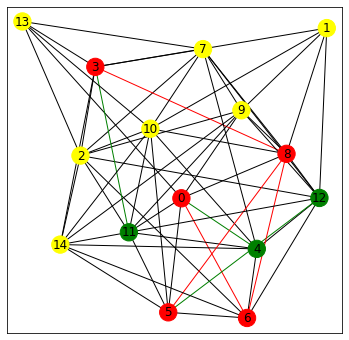

In [15]:
plt.figure(figsize=[6,6])
nx.draw_networkx(graph, node_color=node_colors, edge_color=edge_colors, pos=pos)

As seen above the algorithm adds the edges with the k-minimal edge costs to the tree solution for each terminal node that is a leaf in the original tree. As a consequence none of the terminal nodes remains a leaf in the expanded tree solution.

In [16]:
dict(expanded_steiner_tree.degree(terminals))

{8: 3, 3: 2, 5: 2, 0: 2, 6: 2}

---

### 2.2 PC neighborhood expansion

The previous approach has two major limitations a) the solution of the expansion is not guaranteed to be a tree, b) The selection of the order of neighbors to consider as well as the number of neighbors requires some manual input.

We propose another solution to expand the neighborhood that is inspired by the popularity of Prize-collecting Steiner trees to identify important subnetworks. In fact, we will expand the neighborhood by for each terminal leaf in the Steiner tree solution solve for the PCST with the root being the terminal leaf and the underlying undirected graph being given by the subgraph induced by the set of vertices that is not in the Steiner tree solution plus the root node. This will expand the neighborhood by growing a PCST starting from each terminal leaf.

We will first assign prizes to each node of the graph by randomly sampling from a uniform distribution [0,0.5].

In [17]:
def add_random_prizes(graph):
    prize_dict = {}
    for node in graph.nodes():
        prize = np.random.uniform(0,0.5)
        prize_dict[node] = prize
    nx.set_node_attributes(graph, prize_dict, "prize")
    return graph

In [18]:
graph = add_random_prizes(graph)

Next, we will expand the Steiner tree solution as described before.

In [19]:
def get_pcst_expansion_edge_list(graph, root):
    node_dict = dict(zip(list(graph.nodes()), list(range(len(graph.nodes())))))
    inv_edge_dict = dict(zip(list(range(len(graph.edges()))), list(graph.edges())))
    
    vertices = list(node_dict.values())
    edges = []
    prizes = []
    costs = []
    for node in graph.nodes(data=True):
        prizes.append(node[-1]["prize"])
    for edge in graph.edges(data=True):
        edges.append((node_dict[edge[0]], node_dict[edge[1]]))
        costs.append(edge[-1]["cost"])
    
    root_idx = list(node_dict.keys()).index(root)
    v_idc, e_idc = pcst_fast(edges, prizes, costs, root_idx, 1, "strong", 0)
    selected_edges = [inv_edge_dict[e_idx] for e_idx in e_idc]
    return selected_edges
    
        

In [20]:
def pcst_expansion(graph, steiner_tree):
    st_nodes = list(steiner_tree.nodes())
    expanded_st_edge_list = list(steiner_tree.edges())
    for node in st_nodes:
        if steiner_tree.degree(node) == 1:
            selected_nodes = list(set(graph.nodes()) - set(st_nodes)) + [node]
            selected_subgraph = graph.subgraph(selected_nodes)
            expanded_st_edge_list += get_pcst_expansion_edge_list(selected_subgraph, root=node)
    expanded_steiner_tree = graph.edge_subgraph(expanded_st_edge_list)
    return expanded_steiner_tree

Now let us run the PCST expansion

In [21]:
expanded_steiner_tree = pcst_expansion(graph, steiner_tree)

Let us now visulize the solution. We will show the Steiner tree solution using red edges and vertices. The nodes added by the PCST-based expansion and the corresponding edges are colored in green.

In [22]:
node_colors=[]
for node in graph.nodes():
    if node in steiner_tree.nodes():
        node_colors.append("red")
    elif node in expanded_steiner_tree.nodes():
        node_colors.append("green")
    else:
        node_colors.append("yellow")
        
edge_colors = []
for edge in graph.edges():
    if edge in steiner_tree.edges():
        edge_colors.append("red")
    elif edge in expanded_steiner_tree.edges():
        edge_colors.append("green")
    else:
        edge_colors.append("black")

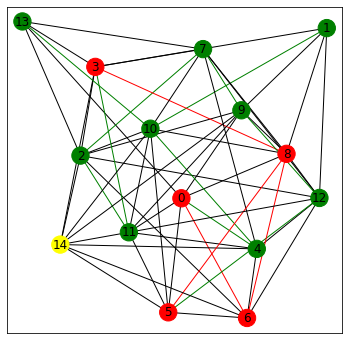

In [23]:
plt.figure(figsize=[6,6])
pos = nx.spring_layout(graph, seed=1234)
nx.draw_networkx(graph, node_color=node_colors, edge_color=edge_colors, pos=pos)

In [24]:
dict(expanded_steiner_tree.degree(terminals))

{8: 3, 3: 2, 5: 2, 0: 2, 6: 2}